In [1]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
### Loading Data
data = pd.read_csv('/home/nicolas/Documentos/Diplomatra en ciencia de datos aplicada/Datasets/data.csv')
tag = pd.read_csv('/home/nicolas/Documentos/Diplomatra en ciencia de datos aplicada/Datasets/tag.csv')

In [3]:
pd.set_option('display.max_columns',30)

In [4]:
data.head(5)

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14


## Limpiando el target

 Sacamos las columnas que no nos van a hacer falta, ya que queremos predecir si cargará o no

In [5]:
tag.drop(columns=[x for x in tag.columns if 'AMT' in x],inplace=True)

Sumaremos todas las cargas que realizaron

In [6]:
tag['Total'] = tag[tag.columns[1:]].sum(axis=1)

In [7]:
tag.drop(columns=[x for x in tag.columns if 'EVT' in x],inplace=True)

In [8]:
tag.head()

,SUSCRIBER_KEY,Total
0,E_63734494_20190215,0
1,E_66977552_20190518,0
2,E_69159695_20180116,4
3,E_65255730_20190416,3
4,E_67893872_20161201,0


Reemplazamos la cantidad de cargar por "False" si cargó, y "True" si no cargó 

In [9]:
tag['Total']= tag['Total']==0

In [10]:
tag.rename(columns={'Total':'Target'},inplace=True)

In [11]:
tag.head(5)

,SUSCRIBER_KEY,Target
0,E_63734494_20190215,True
1,E_66977552_20190518,True
2,E_69159695_20180116,False
3,E_65255730_20190416,False
4,E_67893872_20161201,True


In [12]:
tag['Target'] = tag['Target'].astype(int)

In [13]:
tag.head(5)

,SUSCRIBER_KEY,Target
0,E_63734494_20190215,1
1,E_66977552_20190518,1
2,E_69159695_20180116,0
3,E_65255730_20190416,0
4,E_67893872_20161201,1


In [14]:
fulldata = data.merge(tag, on='SUSCRIBER_KEY')

 Unimos los datasets

In [15]:
fulldata.head()

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12,Target
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0,1
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14,1


In [16]:
del tag
del data

In [17]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 213 entries, SUSCRIBER_KEY to Target
dtypes: float64(103), int64(98), object(12)
memory usage: 521.2+ MB


 ## Empecemos a limpiar columnas 

Todas las que dicen en el documento 'No se usa', Chau

In [18]:
def Borrar_columnas(df,col):
    df.drop(columns=[x for x in df.columns if col in x],inplace=True)

In [19]:
fulldata.drop(columns=[x for x in fulldata.columns if 'ARPU' in x],inplace=True)

In [20]:
fulldata.head()

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12,Target
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0,1
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14,1


Quedaron 5 a eliminar (quedaban 190 después de que el profe eliminó las innecesarias)

In [21]:
que_quedaron= ["USE_LCL_VOI_AMT_M1",
"USE_LCL_VOI_AMT_M2",
"USE_LCL_VOI_AMT_M3",]

In [22]:
fulldata.drop(columns=que_quedaron,inplace=True)

In [23]:
fulldata.shape

(319222, 192)

In [24]:
print(fulldata.columns)

Index(['SUSCRIBER_KEY', 'FECHA_CORTE', 'LAT_PROV_BTS', 'LON_PROV_BTS',
       'LAT_CITY_BTS', 'LON_CITY_BTS', 'VALUE_SEGMENT', 'SEGMENTATION',
       'MICROSEGMENTATION', 'SOURCE',
       ...
       'PACK_DATA_EXP_W4', 'PACK_DATA_EXP_W5', 'PACK_DATA_EXP_W6',
       'PACK_DATA_EXP_W7', 'PACK_DATA_EXP_W8', 'PACK_DATA_EXP_W9',
       'PACK_DATA_EXP_W10', 'PACK_DATA_EXP_W11', 'PACK_DATA_EXP_W12',
       'Target'],
      dtype='object', length=192)


# ME HABÍAN QUEDADO LAS QUE TIENEN UN SOLO VALOR (OJO!!!) 

In [25]:
columnas_a_eliminar = [x for x in fulldata.columns if fulldata[x].nunique()==1]

In [26]:
fulldata.drop(columns=columnas_a_eliminar, inplace=True)

In [27]:
fulldata.shape

(319222, 190)

## Veamos ahora los nulos

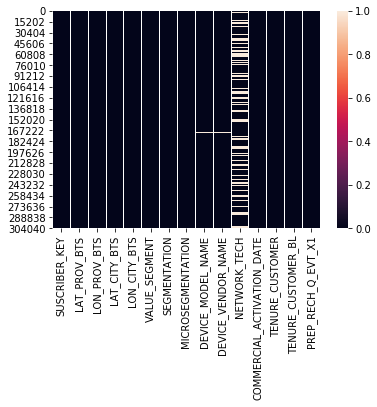

In [28]:
sns.heatmap(fulldata[fulldata.columns[0:15]].isnull())

In [29]:
nullcount = {col:fulldata[col].isnull().sum() for col in fulldata.columns}

Hasta ahí los nulos eran una lista. Ahora con pandas los convertimos en un array

In [30]:
missing = pd.Series(nullcount)

In [31]:
missing

SUSCRIBER_KEY          0
LAT_PROV_BTS         734
LON_PROV_BTS         734
LAT_CITY_BTS         734
LON_CITY_BTS         734
                    ... 
PACK_DATA_EXP_W9       0
PACK_DATA_EXP_W10      0
PACK_DATA_EXP_W11      0
PACK_DATA_EXP_W12      0
Target                 0
Length: 190, dtype: int64

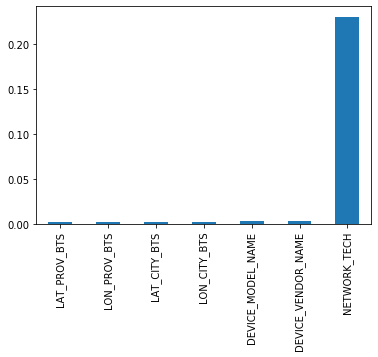

In [32]:
missing[missing>0].div(fulldata.shape[0]).plot.bar()

In [33]:
fulldata.shape[0]

319222

## Imputar network tech

In [34]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.467399
3G     0.272118
NaN    0.229959
2G     0.030524
Name: NETWORK_TECH, dtype: float64

In [35]:
fulldata['NETWORK_TECH'].value_counts(dropna=False)

LTE    149204
3G      86866
NaN     73408
2G       9744
Name: NETWORK_TECH, dtype: int64

In [36]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 190 entries, SUSCRIBER_KEY to Target
dtypes: float64(82), int64(98), object(10)
memory usage: 465.2+ MB


In [37]:
cols = fulldata.columns 
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(cols) - set(num_cols))

In [38]:
cat_columns

['PREP_RECH_LAST_DAY_12W',
 'DEVICE_MODEL_NAME',
 'VALUE_SEGMENT',
 'DEVICE_VENDOR_NAME',
 'SEGMENTATION',
 'PREP_RECH_CHNNL_MODE12W',
 'COMMERCIAL_ACTIVATION_DATE',
 'MICROSEGMENTATION',
 'SUSCRIBER_KEY',
 'NETWORK_TECH']

In [39]:
Cat_fulldata =  fulldata[['SEGMENTATION',
 'PREP_RECH_CHNNL_MODE12W',
 'DEVICE_MODEL_NAME',
 'COMMERCIAL_ACTIVATION_DATE',
 'PREP_RECH_LAST_DAY_12W',
 'DEVICE_VENDOR_NAME',
 'MICROSEGMENTATION',
 'NETWORK_TECH',
 'SUSCRIBER_KEY',
 'VALUE_SEGMENT']].copy()

In [40]:
Cat_fulldata.head(5)

,SEGMENTATION,PREP_RECH_CHNNL_MODE12W,DEVICE_MODEL_NAME,COMMERCIAL_ACTIVATION_DATE,PREP_RECH_LAST_DAY_12W,DEVICE_VENDOR_NAME,MICROSEGMENTATION,NETWORK_TECH,SUSCRIBER_KEY,VALUE_SEGMENT
0,2-PD,"N/A,3;UGW,9",G4 STYLUS (H540),15-FEB-19,19-AUG-19,LG,PD1,LTE,E_63734494_20190215,3 - SILVER
1,7-LOW,"UGW,1",NOT_IDENTIFIED,18-MAY-19,03-JUL-19,NOT_IDENTIFIED,LOW3,NaN,E_66977552_20190518,4 - BRONZE
2,6-OH,"N/A,3;UGW,4",NOT_IDENTIFIED,16-JAN-18,02-SEP-19,NOT_IDENTIFIED,LOW4,3G,E_69159695_20180116,3 - SILVER
3,7-LOW,"UGW,2",JENNY TV 2.8,16-APR-19,01-SEP-19,BLU,LOW3,LTE,E_65255730_20190416,3 - SILVER
4,3-DO,"N/A,1;UGW,4",GALAXY J1 (SM-J111MDS),01-DEC-16,05-SEP-19,SAMSUNG,DO3,LTE,E_67893872_20161201,3 - SILVER


# DESDE ACÁ EMPIEZA LA ÚLTIMA MODIFICACIÓN DE NICO 10/6 18HS

## Lo que va es lo que se debería pegar en el common, donde dice "Acá empieza la parte de modificó Nico"

In [41]:
Recargas = fulldata[['PREP_RECH_Q_EVT_X1','PREP_RECH_Q_EVT_X2','PREP_RECH_Q_EVT_X3','PREP_RECH_AMT_X1',
                     'PREP_RECH_AMT_X2','PREP_RECH_AMT_X3', 'PREP_RECH_Q_MON_12W', 'PREP_RECH_Q_TUE_12W',
                    'PREP_RECH_Q_WEN_12W','PREP_RECH_Q_THUR_12W','PREP_RECH_Q_FRI_12W','PREP_RECH_Q_SAT_12W',
                    'PREP_RECH_Q_SUN_12W','PREP_RECH_NDAYS_LASTRECH_12W',
                    'PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3',
                    'PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7',
                    'PREP_RECH_Q_EVT_W8','PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11',
                    'PREP_RECH_Q_EVT_W12','PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3',
                    'PREP_RECH_AMT_W4','PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8',
                    'PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12']].copy()

In [42]:
Recargas.head(5)

,PREP_RECH_Q_EVT_X1,PREP_RECH_Q_EVT_X2,PREP_RECH_Q_EVT_X3,PREP_RECH_AMT_X1,PREP_RECH_AMT_X2,PREP_RECH_AMT_X3,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W,PREP_RECH_NDAYS_LASTRECH_12W,PREP_RECH_Q_EVT_W1,...,PREP_RECH_Q_EVT_W10,PREP_RECH_Q_EVT_W11,PREP_RECH_Q_EVT_W12,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
0,6,8,4,8.5,13.0,6.0,4,4,4,3,3,3,5,22,0,...,0,0,0,0.0,0.0,3.5,5.0,3.0,8.5,0.0,1.5,6.0,0.0,0.0,0.0
1,0,0,3,0.0,0.0,2.0,0,0,3,0,0,0,0,69,0,...,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,6,4,3,8.0,6.0,1.5,3,3,3,3,0,3,4,8,3,...,0,3,0,1.5,2.0,1.5,3.0,0.0,6.0,0.0,0.0,0.0,0.0,1.5,0.0
3,4,0,0,7.0,0.0,0.0,0,3,0,0,0,0,3,9,0,...,0,0,0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,3,13.0,10.0,10.0,0,3,3,3,0,4,0,5,3,...,3,0,0,3.0,0.0,0.0,10.0,0.0,5.0,0.0,5.0,0.0,10.0,0.0,0.0


In [43]:
Recargas[['PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W1'
          ,'PREP_RECH_Q_EVT_X1']].head(5)

,PREP_RECH_Q_EVT_W4,PREP_RECH_Q_EVT_W3,PREP_RECH_Q_EVT_W2,PREP_RECH_Q_EVT_W1,PREP_RECH_Q_EVT_X1
0,4,4,0,0,6
1,0,0,0,0,0
2,3,3,3,3,6
3,0,3,3,0,4
4,3,0,0,3,4


In [44]:
Recargas[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W5',
          'PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8','PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10',
          'PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12','PREP_RECH_Q_EVT_X1','PREP_RECH_Q_EVT_X2','PREP_RECH_Q_EVT_X3']]

,PREP_RECH_Q_EVT_W1,PREP_RECH_Q_EVT_W2,PREP_RECH_Q_EVT_W3,PREP_RECH_Q_EVT_W4,PREP_RECH_Q_EVT_W5,PREP_RECH_Q_EVT_W6,PREP_RECH_Q_EVT_W7,PREP_RECH_Q_EVT_W8,PREP_RECH_Q_EVT_W9,PREP_RECH_Q_EVT_W10,PREP_RECH_Q_EVT_W11,PREP_RECH_Q_EVT_W12,PREP_RECH_Q_EVT_X1,PREP_RECH_Q_EVT_X2,PREP_RECH_Q_EVT_X3
0,0,0,4,4,3,6,0,3,4,0,0,0,6,8,4
1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3
2,3,3,3,3,0,4,0,0,0,0,3,0,6,4,3
3,0,3,3,0,0,0,0,0,0,0,0,0,4,0,0
4,3,0,0,3,0,3,0,3,0,3,0,0,4,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,5,0,0,0,5
319218,0,0,0,4,3,0,0,4,3,3,4,3,4,5,7
319219,3,0,3,4,0,3,3,3,0,0,0,3,6,5,3
319220,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3


In [45]:
Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4','PREP_RECH_AMT_W5',
         'PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8','PREP_RECH_AMT_W9','PREP_RECH_AMT_W10',
         'PREP_RECH_AMT_W11','PREP_RECH_AMT_W12','PREP_RECH_AMT_X1','PREP_RECH_AMT_X2','PREP_RECH_AMT_X3']].head(5)

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12,PREP_RECH_AMT_X1,PREP_RECH_AMT_X2,PREP_RECH_AMT_X3
0,0.0,0.0,3.5,5.0,3.0,8.5,0.0,1.5,6.0,0.0,0.0,0.0,8.5,13.0,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
2,1.5,2.0,1.5,3.0,0.0,6.0,0.0,0.0,0.0,0.0,1.5,0.0,8.0,6.0,1.5
3,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
4,3.0,0.0,0.0,10.0,0.0,5.0,0.0,5.0,0.0,10.0,0.0,0.0,13.0,10.0,10.0


# Vamos a comparar las cantidades de recargas acumuladas, con la cantidad de recargas acumuladas mensuales

In [46]:
Cant_rec_mes1= Recargas[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4'
                        ]].sum(axis=1)

In [47]:
Cant_rec_mes2= Recargas[['PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8'
                        ]].sum(axis=1)

In [48]:
Cant_rec_mes3= Recargas[['PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12'
                        ]].sum(axis=1)

In [49]:
(Cant_rec_mes1 == Recargas['PREP_RECH_Q_EVT_X1']).value_counts()

False    191491
True     127731
dtype: int64

In [50]:
(Cant_rec_mes2 == Recargas['PREP_RECH_Q_EVT_X2']).value_counts()

False    192949
True     126273
dtype: int64

In [51]:
(Cant_rec_mes3 == Recargas['PREP_RECH_Q_EVT_X3']).value_counts()

False    201542
True     117680
dtype: int64

Consideramos que la cantidad de datos que no coinciden es apreciable, entonces decidimos sacar los datos

In [52]:
#fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_X' in x],inplace=True)
Borrar_columnas(fulldata,'PREP_RECH_Q_EVT_W')

In [53]:
#fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_W' in x],inplace=True)
Borrar_columnas(fulldata,'PREP_RECH_Q_EVT_W')

# Vamos a comparar los montos de recargas acumuladas, con los montos de recargas acumuladas mensuales

In [54]:
Mont_rec_mes1= Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4'
                        ]].sum(axis=1)

In [55]:
Mont_rec_mes2= Recargas[['PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8'
                        ]].sum(axis=1)

In [56]:
Mont_rec_mes3= Recargas[['PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12'
                        ]].sum(axis=1)

In [57]:
(Mont_rec_mes1 == Recargas['PREP_RECH_AMT_X1']).value_counts()

True     319070
False       152
dtype: int64

In [58]:
(Mont_rec_mes2 == Recargas['PREP_RECH_AMT_X2']).value_counts()

True     319061
False       161
dtype: int64

In [59]:
(Mont_rec_mes3 == Recargas['PREP_RECH_AMT_X3']).value_counts()

True     319059
False       163
dtype: int64

Como los valores difieren en una cantidad indistinguible(menos del 1%) podemos conciderar que presentan la misma información. Por tal motivo se decide sacar las columnas de montos acumulados

In [60]:
#fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_AMT_X' in x],inplace=True)
Borrar_columnas(fulldata,'PREP_RECH_AMT_X')

In [61]:
fulldata.shape

(319222, 175)

### Seguimos trabajando con las recargas

Eliminamos en el dataframe de recargas, las mismas columnas que eliminamos en el fulldata

In [62]:
#Recargas.drop(columns=[x for x in Recargas.columns if 'PREP_RECH_AMT_X' in x],inplace=True)
Borrar_columnas(Recargas,'PREP_RECH_AMT_X')

In [63]:
#Recargas.drop(columns=[x for x in Recargas.columns if 'PREP_RECH_Q_EVT_W' in x],inplace=True)
Borrar_columnas(Recargas,'PREP_RECH_Q_EVT_W')

In [64]:
#Recargas.drop(columns=[x for x in Recargas.columns if 'PREP_RECH_Q_EVT_X' in x],inplace=True)
Borrar_columnas(Recargas,'PREP_RECH_Q_EVT_X')

In [65]:
Recargas.shape

(319222, 20)

In [66]:
Recargas.columns

Index(['PREP_RECH_Q_MON_12W', 'PREP_RECH_Q_TUE_12W', 'PREP_RECH_Q_WEN_12W',
       'PREP_RECH_Q_THUR_12W', 'PREP_RECH_Q_FRI_12W', 'PREP_RECH_Q_SAT_12W',
       'PREP_RECH_Q_SUN_12W', 'PREP_RECH_NDAYS_LASTRECH_12W',
       'PREP_RECH_AMT_W1', 'PREP_RECH_AMT_W2', 'PREP_RECH_AMT_W3',
       'PREP_RECH_AMT_W4', 'PREP_RECH_AMT_W5', 'PREP_RECH_AMT_W6',
       'PREP_RECH_AMT_W7', 'PREP_RECH_AMT_W8', 'PREP_RECH_AMT_W9',
       'PREP_RECH_AMT_W10', 'PREP_RECH_AMT_W11', 'PREP_RECH_AMT_W12'],
      dtype='object')

In [67]:
Recargas[[x for x in Recargas.columns if 'PREP_RECH_Q' in x]]

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
0,4,4,4,3,3,3,5
1,0,0,3,0,0,0,0
2,3,3,3,3,0,3,4
3,0,3,0,0,0,0,3
4,0,3,3,3,0,4,0
...,...,...,...,...,...,...,...
319217,0,0,4,0,0,3,0
319218,4,5,3,4,3,0,3
319219,0,0,3,0,0,0,9
319220,0,0,0,3,0,0,0


# Análisis de correlación

### Correlación entre Cantidad de recargas en x día durante las 12 semanas

In [68]:
Cant_rec_en_dias= Recargas[[x for x in Recargas.columns if 'PREP_RECH_Q' in x]]
Cant_rec_en_dias.describe()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.770473,2.484537,2.536645,2.655685,2.839980,2.566596,2.336622
std,2.633008,2.520506,2.517774,2.534744,2.589916,2.572251,2.470489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,39.000000,43.000000,38.000000,37.000000,38.000000,51.000000,38.000000


In [69]:
Cant_rec_en_dias.corr()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
PREP_RECH_Q_MON_12W,1.000000,0.379673,0.354563,0.382599,0.351402,0.284211,0.304759
PREP_RECH_Q_TUE_12W,0.379673,1.000000,0.383747,0.352447,0.359342,0.335362,0.277231
PREP_RECH_Q_WEN_12W,0.354563,0.383747,1.000000,0.381315,0.346658,0.328482,0.326740
PREP_RECH_Q_THUR_12W,0.382599,0.352447,0.381315,1.000000,0.381090,0.289958,0.315796
PREP_RECH_Q_FRI_12W,0.351402,0.359342,0.346658,0.381090,1.000000,0.320213,0.283657
PREP_RECH_Q_SAT_12W,0.284211,0.335362,0.328482,0.289958,0.320213,1.000000,0.327095
PREP_RECH_Q_SUN_12W,0.304759,0.277231,0.326740,0.315796,0.283657,0.327095,1.000000


Vemos que los coeficientes de Pearson entre las variables expresan que no hay correlación entre las variables analizadas

### Correlación entre montos acumulados de recargas por semana

In [70]:
Mont_Acum_por_sem= Recargas[[x for x in Recargas.columns if 'PREP_RECH_AMT_W' in x]]
Mont_Acum_por_sem.describe()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.732087,3.217064,2.817290,3.549195,2.998092,3.173191,2.840202,3.345359,3.122188,3.111067,3.377898,3.160723
std,3.857857,4.218097,3.879877,4.514366,4.087966,4.171063,3.952560,4.252033,4.167941,4.133527,4.239955,4.122492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,3.000000,1.500000,2.000000,0.000000,3.000000,2.000000,2.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,85.000000,345.000000,133.000000,170.000000,98.000000,168.220000,125.000000,123.690000,150.000000,120.000000,210.000000,115.000000


In [71]:
Mont_Acum_por_sem.corr()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
PREP_RECH_AMT_W1,1.000000,0.387587,0.450786,0.404695,0.449589,0.418191,0.389979,0.362100,0.379022,0.389557,0.352022,0.336874
PREP_RECH_AMT_W2,0.387587,1.000000,0.416184,0.460712,0.431145,0.462956,0.418715,0.406668,0.385504,0.374179,0.413962,0.332321
PREP_RECH_AMT_W3,0.450786,0.416184,1.000000,0.398843,0.461153,0.423277,0.450026,0.412411,0.397969,0.383072,0.376044,0.384792
PREP_RECH_AMT_W4,0.404695,0.460712,0.398843,1.000000,0.428096,0.456106,0.411002,0.473736,0.432682,0.384098,0.394640,0.356400
PREP_RECH_AMT_W5,0.449589,0.431145,0.461153,0.428096,1.000000,0.426950,0.454438,0.419277,0.459938,0.432653,0.397538,0.377575
PREP_RECH_AMT_W6,0.418191,0.462956,0.423277,0.456106,0.426950,1.000000,0.416285,0.435692,0.432031,0.443515,0.436375,0.376568
PREP_RECH_AMT_W7,0.389979,0.418715,0.450026,0.411002,0.454438,0.416285,1.000000,0.390575,0.450066,0.419207,0.440426,0.408003
PREP_RECH_AMT_W8,0.362100,0.406668,0.412411,0.473736,0.419277,0.435692,0.390575,1.000000,0.406533,0.431688,0.407624,0.415469
PREP_RECH_AMT_W9,0.379022,0.385504,0.397969,0.432682,0.459938,0.432031,0.450066,0.406533,1.000000,0.426734,0.446665,0.414405
PREP_RECH_AMT_W10,0.389557,0.374179,0.383072,0.384098,0.432653,0.443515,0.419207,0.431688,0.426734,1.000000,0.402197,0.437371


Vemos que los coeficientes de Pearson entre las variables expresan que no hay correlación entre ellas.

# Outliers

### Cantidad de recargas en x dias durante las 12 semanas

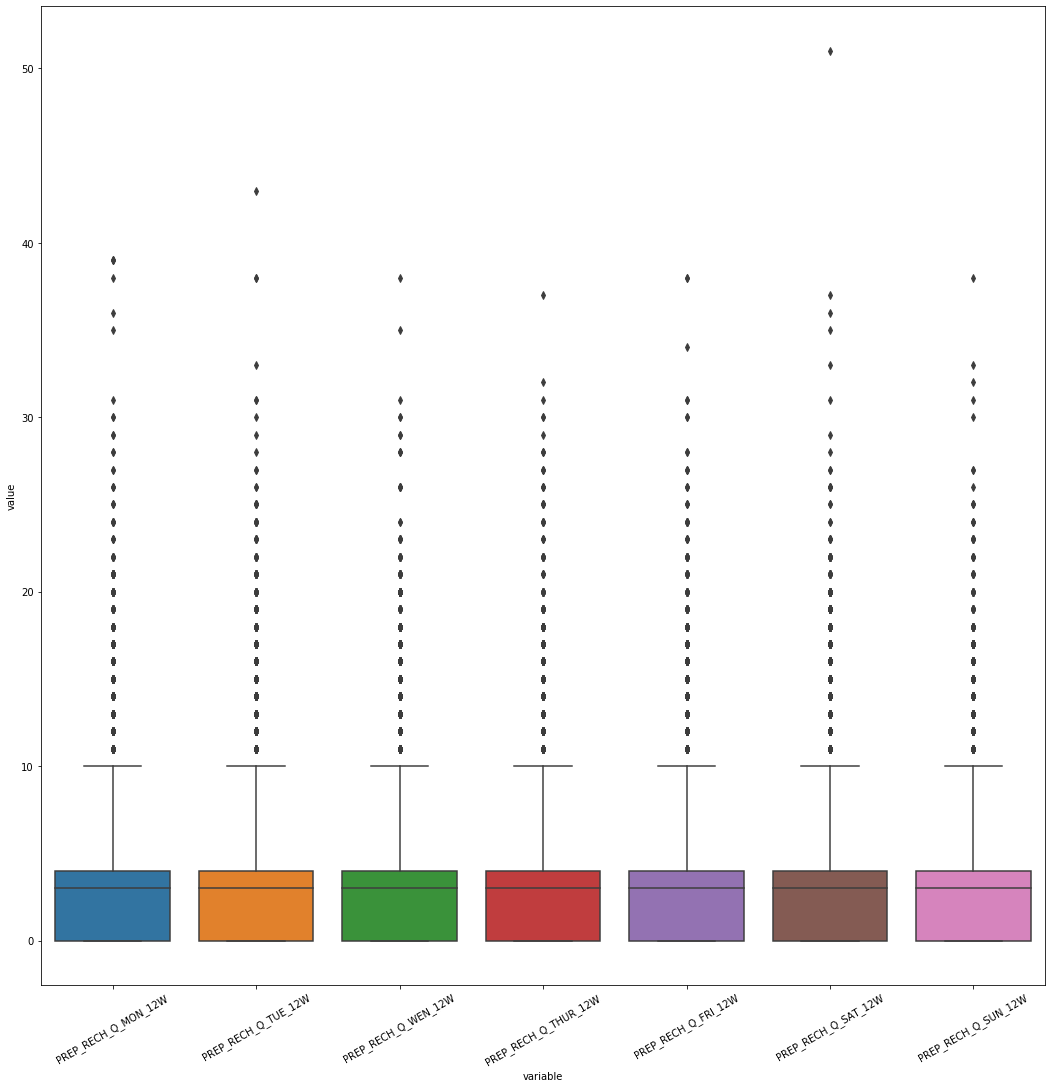

In [72]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Cant_rec_en_dias))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [73]:
Cant_rec_en_dias.describe()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.770473,2.484537,2.536645,2.655685,2.839980,2.566596,2.336622
std,2.633008,2.520506,2.517774,2.534744,2.589916,2.572251,2.470489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,39.000000,43.000000,38.000000,37.000000,38.000000,51.000000,38.000000


Vemos que en todas las columnas el rango intercuartil es 4. Así que vamos a ver cuantas mediciones superan en dos veces el rango (y lo dividimos por el total de filas para obtener una frecuencia relativa). 

In [130]:
print(((Recargas['PREP_RECH_Q_MON_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_TUE_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_WEN_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_THUR_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_FRI_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_SAT_12W']>12).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_SUN_12W']>12).value_counts())/ len(Recargas.index)
     )

False    0.996319
True     0.003681
Name: PREP_RECH_Q_MON_12W, dtype: float64 False    0.997597
True     0.002403
Name: PREP_RECH_Q_TUE_12W, dtype: float64 False    0.997331
True     0.002669
Name: PREP_RECH_Q_WEN_12W, dtype: float64 False    0.997387
True     0.002613
Name: PREP_RECH_Q_THUR_12W, dtype: float64 False    0.996955
True     0.003045
Name: PREP_RECH_Q_FRI_12W, dtype: float64 False    0.996877
True     0.003123
Name: PREP_RECH_Q_SAT_12W, dtype: float64 False    0.997679
True     0.002321
Name: PREP_RECH_Q_SUN_12W, dtype: float64


Además veamos el coeficiente de variación.

In [81]:
(Recargas['PREP_RECH_Q_MON_12W'].std()/Recargas['PREP_RECH_Q_MON_12W'].mean())*100

95.03818759314608

### Se calcula uno sólo, pero al ver la tabla del "describe" se puede notar que los demás coeficientes también son superiores al 90%. Por lo tanto, se igualará a todos los valores superiores a dos veces el rango, por el valor de 4+2*R, con el objetivo de influir lo menos posible en la distribución, y que los valores atípicos no influyan de manera apreciable en la media y desvío estándar.

In [124]:
### Función que nos modifica los outliers por el número o variable que le ingresemos en y

def Sacar_outliers(x,y):
    x=np.where(x>y, x==y, x)
  

In [125]:
fulldata[['PREP_RECH_Q_MON_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_MON_12W']],12)
fulldata[['PREP_RECH_Q_TUE_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_TUE_12W']],12)
fulldata[['PREP_RECH_Q_WEN_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_WEN_12W']],12)
fulldata[['PREP_RECH_Q_THUR_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_THUR_12W']],12)
fulldata[['PREP_RECH_Q_FRI_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_FRI_12W']],12)
fulldata[['PREP_RECH_Q_SAT_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_SAT_12W']],12)
fulldata[['PREP_RECH_Q_SUN_12W']]= Sacar_outliers(fulldata[['PREP_RECH_Q_SUN_12W']],12)

In [123]:
((fulldata['PREP_RECH_Q_SAT_12W']>12).value_counts())/ len(fulldata.index)

False    1.0
Name: PREP_RECH_Q_SAT_12W, dtype: float64

### Monto acumulado de recargas por semana

In [72]:
type(Recargas[[x for x in Recargas.columns if 'PREP_RECH_AMT_W' in x]])

pandas.core.frame.DataFrame

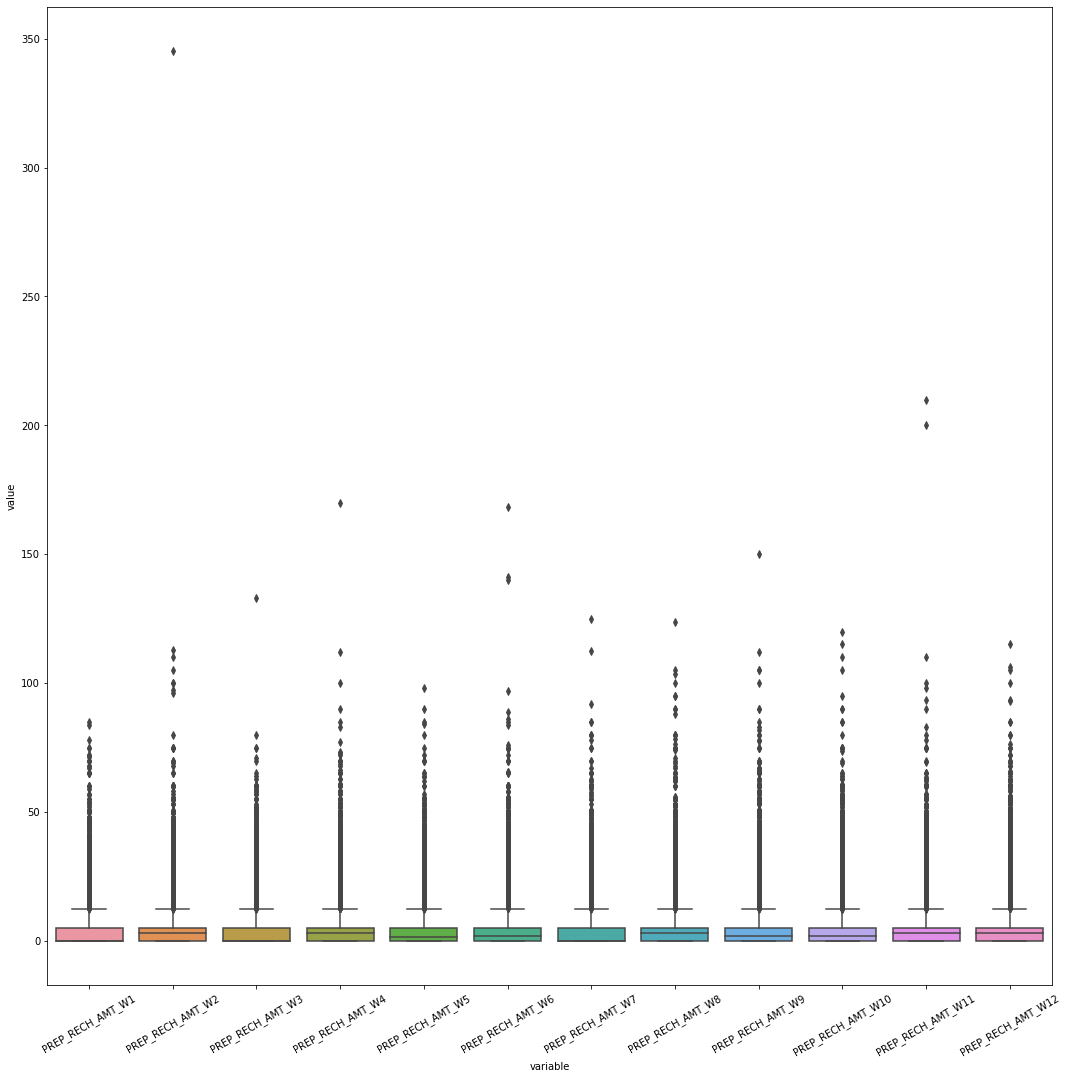

In [119]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Mont_Acum_por_sem))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [120]:
Mont_Acum_por_sem.describe()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.732087,3.217064,2.817290,3.549195,2.998092,3.173191,2.840202,3.345359,3.122188,3.111067,3.377898,3.160723
std,3.857857,4.218097,3.879877,4.514366,4.087966,4.171063,3.952560,4.252033,4.167941,4.133527,4.239955,4.122492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,3.000000,1.500000,2.000000,0.000000,3.000000,2.000000,2.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,85.000000,345.000000,133.000000,170.000000,98.000000,168.220000,125.000000,123.690000,150.000000,120.000000,210.000000,115.000000


Vemos que en todas las columnas el rango intercuartil es 5(Q3-Q1). Así que vamos a ver cuantas mediciones superan en tres veces el rango (más el tercer cuartil), y lo dividimos por el total de filas para obtener una frecuencia relativa. 

In [136]:
print(((Recargas['PREP_RECH_AMT_W1']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W2']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W3']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W4']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W5']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W6']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W7']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W8']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W9']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W10']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W11']>20).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W12']>20).value_counts())/ len(Recargas.index)
     )

False    0.996435
True     0.003565
Name: PREP_RECH_AMT_W1, dtype: float64 False    0.995423
True     0.004577
Name: PREP_RECH_AMT_W2, dtype: float64 False    0.996219
True     0.003781
Name: PREP_RECH_AMT_W3, dtype: float64 False    0.994061
True     0.005939
Name: PREP_RECH_AMT_W4, dtype: float64 False    0.995442
True     0.004558
Name: PREP_RECH_AMT_W5, dtype: float64 False    0.995282
True     0.004718
Name: PREP_RECH_AMT_W6, dtype: float64 False    0.995946
True     0.004054
Name: PREP_RECH_AMT_W7, dtype: float64 False    0.9948
True     0.0052
Name: PREP_RECH_AMT_W8, dtype: float64 False    0.995003
True     0.004997
Name: PREP_RECH_AMT_W9, dtype: float64 False    0.995104
True     0.004896
Name: PREP_RECH_AMT_W10, dtype: float64 False    0.994856
True     0.005144
Name: PREP_RECH_AMT_W11, dtype: float64 False    0.995191
True     0.004809
Name: PREP_RECH_AMT_W12, dtype: float64


Además veamos el coeficiente de variación.

In [137]:
(Recargas['PREP_RECH_AMT_W1'].std()/Recargas['PREP_RECH_AMT_W1'].mean())*100

141.2055207208845

### Se calcula uno sólo, pero al ver la tabla del "describe" se puede notar que los demás coeficientes son muy altos, debido a que el desvío estándar es superior a la media. Por lo tanto, se igualará a todos los valores superiores a tres veces el rango, por el valor de 5+3*R, con el objetivo de influir lo menos posible en la distribución, y que los valores atípicos no influyan de manera apreciable en la media y desvío estándar.

In [140]:
fulldata[['PREP_RECH_AMT_W1']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W1']],20)
fulldata[['PREP_RECH_AMT_W2']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W2']],20)
fulldata[['PREP_RECH_AMT_W3']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W3']],20)
fulldata[['PREP_RECH_AMT_W4']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W4']],20)
fulldata[['PREP_RECH_AMT_W5']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W5']],20)
fulldata[['PREP_RECH_AMT_W6']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W6']],20)
fulldata[['PREP_RECH_AMT_W7']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W7']],20)
fulldata[['PREP_RECH_AMT_W8']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W8']],20)
fulldata[['PREP_RECH_AMT_W9']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W9']],20)
fulldata[['PREP_RECH_AMT_W10']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W10']],20)
fulldata[['PREP_RECH_AMT_W11']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W11']],20)
fulldata[['PREP_RECH_AMT_W12']]= Sacar_outliers(fulldata[['PREP_RECH_AMT_W12']],20)

In [141]:
((fulldata['PREP_RECH_AMT_W12']>20).value_counts())/ len(fulldata.index)

False    1.0
Name: PREP_RECH_AMT_W12, dtype: float64

### Días desde la última recarga

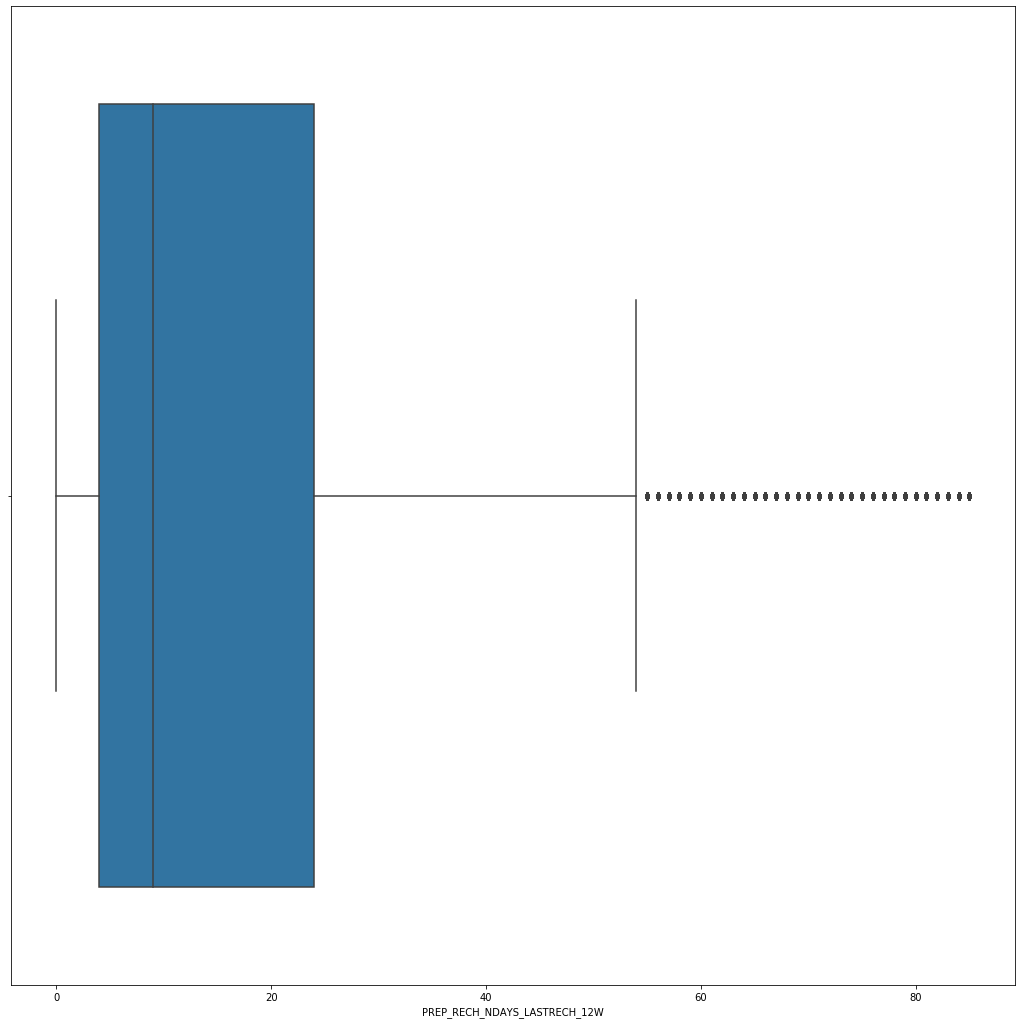

In [74]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x=Recargas['PREP_RECH_NDAYS_LASTRECH_12W'])

In [142]:
Recargas['PREP_RECH_NDAYS_LASTRECH_12W'].describe()

count    319222.000000
mean         17.858826
std          20.374863
min           0.000000
25%           4.000000
50%           9.000000
75%          24.000000
max          85.000000
Name: PREP_RECH_NDAYS_LASTRECH_12W, dtype: float64

## Se decide no modificar la columna, debido a que el valor máximo que asume la varible es 85, está muy cerca de 3*R+Q3

# Se trabajará la columna de fechas de alta del fulldata

In [92]:
## Se hará que python interprete a la columna de activación comercial como fecha
fulldata['Date'] = pd.to_datetime(fulldata['COMMERCIAL_ACTIVATION_DATE'], format='%d-%b-%y') 
fulldata['Dayofweek'] = fulldata['Date'].dt.dayofweek 
fulldata['Month'] = fulldata['Date'].dt.month 
fulldata['Year'] = fulldata['Date'].dt.year 
fulldata['Period'] = fulldata['Date'].dt.to_period('M') 
fulldata.sort_values('Date', inplace=True) 

In [93]:
fulldata[['COMMERCIAL_ACTIVATION_DATE', 'Date', 'Dayofweek', 'Month', 'Year', 'Period']]

,COMMERCIAL_ACTIVATION_DATE,Date,Dayofweek,Month,Year,Period
171412,10-JUL-11,2011-07-10,6,7,2011,2011-07
287516,10-JUL-11,2011-07-10,6,7,2011,2011-07
180405,25-NOV-11,2011-11-25,4,11,2011,2011-11
298876,25-NOV-11,2011-11-25,4,11,2011,2011-11
255393,22-APR-12,2012-04-22,6,4,2012,2012-04
...,...,...,...,...,...,...
205266,17-JUN-19,2019-06-17,0,6,2019,2019-06
100393,17-JUN-19,2019-06-17,0,6,2019,2019-06
229099,17-JUN-19,2019-06-17,0,6,2019,2019-06
148485,17-JUN-19,2019-06-17,0,6,2019,2019-06


Ahora usaremos una tabla pivot para calcular la cantidad de activaciones que por mes en cada año

In [94]:
pd.pivot_table(data=fulldata,
               index=['Year'],
               columns=['Month'],
               aggfunc=['size']
              )

size                                                               \
Month      1       2        3        4        5        6        7       8    
Year                                                                         
2011      NaN     NaN      NaN      NaN      NaN      NaN      2.0     NaN   
2012      NaN     NaN      NaN      5.0      3.0      NaN      NaN     NaN   
2013      NaN     NaN      NaN      NaN      2.0      NaN     24.0     NaN   
2014      NaN     NaN      NaN      NaN      NaN      NaN      NaN     NaN   
2015     14.0     NaN     14.0      NaN   2322.0  34682.0  55817.0  3208.0   
2016   2284.0  2160.0   2231.0   2261.0   6674.0   3943.0   2310.0  2569.0   
2017   3481.0  3245.0   3591.0   2967.0   3178.0   3743.0   3231.0  3511.0   
2018   4730.0  3945.0   5102.0   4927.0   4517.0   5194.0   5848.0  6149.0   
2019   9615.0  9536.0  11358.0  11440.0  13163.0   8855.0      NaN     NaN   

                                        
Month      9       10      11       12  
Year                                    
2011      NaN     NaN     2.0      NaN  
2012      7.0     NaN     NaN      NaN  
2013      NaN     NaN     NaN      NaN  
2014      NaN     NaN    49.0     73.0  
2015   1926.0  2068.0  1968.0   2829.0  
2016   2621.0  2846.0  2626.0   4515.0  
2017   3273.0  3790.0  3426.0   5582.0  
2018   5959.0  6395.0  6614.0  10802.0  
2019      NaN     NaN     NaN      NaN

## Sacaremos todas las filas de los periodos anteriores al periodo en el cual se dan de alta líneas de manera consecutiva

In [97]:
period = pd.to_datetime('2015-05').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]

In [113]:
pivot_table = pd.pivot_table(data=fulldata,
               index=['Year'],
               columns=['Month'],
               aggfunc=['size'],
               fill_value=0
              )
pivot_table

size                                                                 \
Month    1     2      3      4      5     6     7     8     9     10    11   
Year                                                                         
2015      0     0      0      0      0     0     0  3208  1926  2068  1968   
2016   2284  2160   2231   2261   6674  3943  2310  2569  2621  2846  2626   
2017   3481  3245   3591   2967   3178  3743  3231  3511  3273  3790  3426   
2018   4730  3945   5102   4927   4517  5194  5848  6149  5959  6395  6614   
2019   9615  9536  11358  11440  13163  8855     0     0     0     0     0   

              
Month     12  
Year          
2015    2829  
2016    4515  
2017    5582  
2018   10802  
2019       0

In [114]:
total_rows = fulldata.shape[0]
total_rows

226206

Ahora veamos que pasa en términos de frecuencias relativas en la tabla pivot

In [115]:
pivot_table.divide(total_rows) * 100

size                                                              \
Month        1         2         3         4         5         6         7    
Year                                                                          
2015   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016   1.009699  0.954882  0.986269  0.999531  2.950408  1.743101  1.021193   
2017   1.538863  1.434533  1.587491  1.311636  1.404914  1.654686  1.428344   
2018   2.091014  1.743986  2.255466  2.178103  1.996852  2.296137  2.585254   
2019   4.250550  4.215626  5.021087  5.057337  5.819032  3.914573  0.000000   

                                                         
Month        8         9         10        11        12  
Year                                                     
2015   1.418176  0.851436  0.914211  0.870003  1.250630  
2016   1.135690  1.158678  1.258145  1.160889  1.995968  
2017   1.552125  1.446911  1.675464  1.514549  2.467662  
2018   2.718319  2.634324  2.827069  2.923884  4.775293  
2019   0.000000  0.000000  0.000000  0.000000  0.000000

Vemos que la mayoría de las frecuencias relativas son menores que 4,2 y tenemos valores en junio y julio del 2015 muy superiores al 4,2. Por lo tanto, se decide sacar todo el periodo menor a agosto de 2015, por considerarlos datos erroneos que podrían ensuciar el modelo

In [116]:
period = pd.to_datetime('2015-08').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]
print(fulldata.shape[0])

226206
